In [1]:
import zipfile
import datetime
import string
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

# assert tf.test.is_gpu_available(), 'No GPU is available.'

data_dir = '.'
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for .\fonts.zip


Filtering fonts.: 100%|████████████████████████████████████████████████████████████| 2746/2746 [01:13<00:00, 37.15it/s]


Looking for .\backgrounds.zip


The first generated text is: 314932 members in 1828 when
The first generated validation image (below) contains: Mo
re settled it
actually benefits
from such rando
mness in many la
nguages are rea
dil
y available


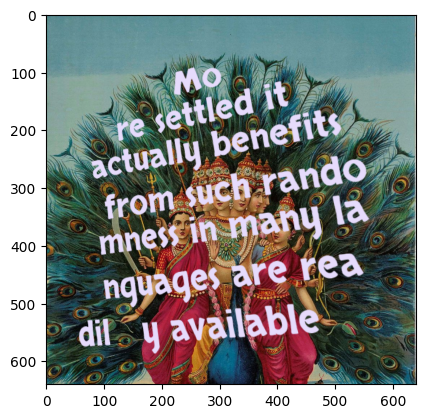

In [2]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [3]:
lines

[[(array([[215.77606, 101.61109],
          [265.78894,  89.27543],
          [271.9919 , 131.18767],
          [221.3778 , 142.80684]], dtype=float32),
   'M'),
  (array([[266.96747 ,  97.238434],
          [301.21042 ,  88.9038  ],
          [306.5767  , 123.248245],
          [271.9919  , 131.18767 ]], dtype=float32),
   'o')],
 [(array([[120.28481, 188.86874],
          [141.76265, 184.14352],
          [145.43285, 215.62393],
          [123.76965, 220.10043]], dtype=float32),
   'r'),
  (array([[141.76265, 184.14352],
          [169.5851 , 178.02245],
          [173.60905, 210.71416],
          [145.53555, 216.50482]], dtype=float32),
   'e'),
  (array([[173.39001, 208.9346 ],
          [190.71544, 205.34799],
          [190.71544, 205.34799],
          [173.39001, 208.9346 ]], dtype=float32),
   ' '),
  (array([[186.64957, 173.36124],
          [204.0654 , 169.52324],
          [208.64296, 204.41377],
          [191.05693, 208.03462]], dtype=float32),
   's'),
  (array([[204.1818

In [4]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for C:\Users\charl\.keras-ocr\craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\charl\.keras-ocr\crnn_kurapan_notop.h5


In [ ]:
detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size),
    batch_size=detector_batch_size
)

226/827 [=======>......................] - ETA: 2:26:48 - loss: 0.0080